In [2]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xg
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import register_matplotlib_converters

from finance.utilities import utils
from finance.data_science.utilities import financial_utils, time_series_utils

In [3]:
register_matplotlib_converters()

%matplotlib notebook
%matplotlib inline

# Options

In [4]:
_SYMBOL = 'KO'
_DATE = '2020-03-18'

In [5]:
query = f"""
    select *
    from td.equities
    where symbol = '{_SYMBOL}'
        and market_datetime::date = '{_DATE}'
    limit 10
    """
stocks = utils.query_db(query=query)
stocks.head(3).T

,0
symbol,KO
open,44.74
high,45.15
low,41.59
close,44.85
volume,3.54083e+07
market_datetime_epoch,1584507600000.0
empty,False
market_datetime,2020-03-18 05:00:00
file_datetime,2020-04-19 00:09:51


In [6]:
query = f"""
    select
        symbol
        , put_call
        , put_call = 'CALL' as is_call
        , description
        , bid
        , ask
        , last
        , close_price
        , total_volume
        , open_interest
        , strike
        , days_to_expiration
        , expiration_date_from_epoch::date
        , file_datetime::date
    from td.options
    where file_datetime::date = '{_DATE}'
        and symbol = '{_SYMBOL}'
    order by put_call, days_to_expiration, strike
    """
options = utils.query_db(query=query)
options.head(3).T

,0,1,2
symbol,KO,KO,KO
put_call,CALL,CALL,CALL
is_call,True,True,True
description,KO Mar 20 2020 30 Call,KO Mar 20 2020 32.5 Call,KO Mar 20 2020 35 Call
bid,14.5,12.1,9.5
ask,19.4,16.6,14.25
last,0,14.58,10.97
close_price,17.18,14.68,12.21
total_volume,0,0,0
open_interest,0,3,0


### Put call parity

In [23]:
# call and put cols
_options = options.copy()
_options['call_ask'] = _options.apply(lambda x: x['ask'] if x['is_call'] else 0, axis=1)
_options['put_ask'] = _options.apply(lambda x: x['ask'] if not x['is_call'] else 0, axis=1)

In [24]:
# parity
_groups = ['symbol', 'strike', 'days_to_expiration', 'expiration_date_from_epoch']
_aggs = {'call_ask': 'max', 'put_ask': 'max'}
parity = _options.groupby(_groups).agg(_aggs)

parity['forward'] = parity['call_ask'] - parity['put_ask']
parity['cumulative_premium'] = parity['call_ask'] + parity['put_ask']
parity = parity.reset_index()

parity['erdt'] = (stocks['open'].values - parity['forward'])/parity['strike']
parity['rdt'] = np.log(parity['erdt'])
parity['rd'] = parity['rdt'] * (parity['days_to_expiration']/360)

# break even
parity['call_break_even'] = parity['call_ask'] + parity['strike']
parity['put_break_even'] = parity['strike'] - parity['put_ask']
parity['call_distance'] = parity['call_break_even'] - stocks['open'].values
parity['put_distance'] = stocks['open'].values - parity['put_break_even']

parity['percent_call_distance'] = parity['call_distance']/stocks['open'].values

parity.head()

,symbol,strike,days_to_expiration,expiration_date_from_epoch,call_ask,put_ask,forward,cumulative_premium,erdt,rdt,rd,call_break_even,put_break_even,call_distance,put_distance,percent_call_distance
0,KO,22.5,58.0,2020-05-15,26.95,1.49,25.46,28.44,0.856889,-0.154447,-0.024883,49.45,21.01,4.71,23.73,0.105275
1,KO,22.5,156.0,2020-08-21,27.25,0.81,26.44,28.06,0.813333,-0.206614,-0.089533,49.75,21.69,5.01,23.05,0.111980
2,KO,22.5,275.0,2020-12-18,27.25,1.08,26.17,28.33,0.825333,-0.191968,-0.146642,49.75,21.42,5.01,23.32,0.111980
3,KO,22.5,674.0,2022-01-21,27.50,3.80,23.70,31.30,0.935111,-0.067090,-0.125607,50.00,18.70,5.26,26.04,0.117568
4,KO,23.0,93.0,2020-06-19,26.70,1.00,25.70,27.70,0.827826,-0.188952,-0.048813,49.70,22.00,4.96,22.74,0.110863


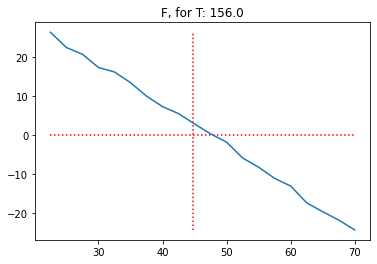

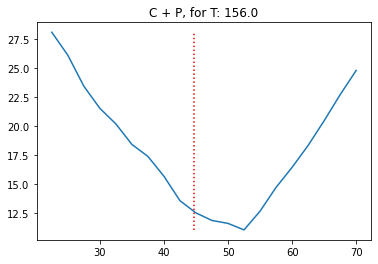

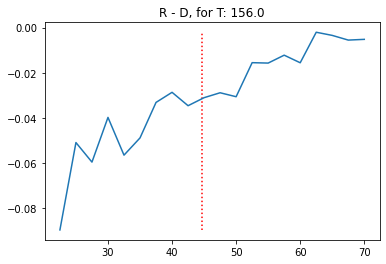

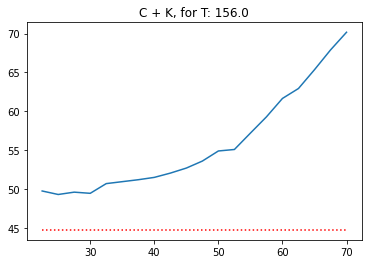

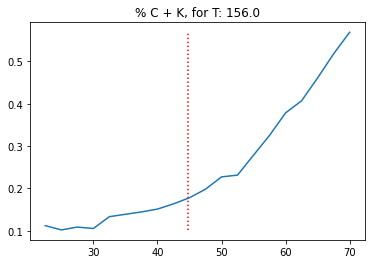

In [44]:
_N_EXPIRATION = 9
_expiration = np.sort(parity['days_to_expiration'].unique())[_N_EXPIRATION]
_s = parity[parity['days_to_expiration'] == _expiration]

def plot(title, x, y, vline=None, ymin=None, ymax=None, hline=None, xmin=None, xmax=None):
    plt.title(title)
    plt.plot(x, y)
    if vline is not None:
        plt.vlines(
            vline,
            ymin=ymin,
            ymax=ymax,
            colors='r',
            linestyles='dotted'
        )
    if hline is not None:
        plt.hlines(
            hline,
            xmin=xmin,
            xmax=xmax,
            colors='r',
            linestyles='dotted'
        )
    plt.show()

plot(
    title=f'F, for T: {_expiration}',
    x=_s['strike'], 
    y=_s['forward'],
    vline=stocks['open'],
    ymin=_s['forward'].min(),
    ymax=_s['forward'].max(),
    hline=0,
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max(),
)

plot(
    title=f'C + P, for T: {_expiration}',
    x=_s['strike'],
    y=_s['cumulative_premium'],
    vline=stocks['open'],
    ymin=_s['cumulative_premium'].min(),
    ymax=_s['cumulative_premium'].max()
)

plot(
    title=f'R - D, for T: {_expiration}',
    x=_s['strike'],
    y=_s['rd'],
    vline=stocks['open'],
    ymin=_s['rd'].min(),
    ymax=_s['rd'].max()
)

plot(
    title=f'C + K, for T: {_expiration}',
    x=_s['strike'],
    y=_s['call_break_even'],
    hline=stocks['open'],
    xmin=_s['strike'].min(),
    xmax=_s['strike'].max()
)

plot(
    title=f'% C + K, for T: {_expiration}',
    x=_s['strike'],
    y=_s['percent_call_distance'],
    vline=stocks['open'],
    ymin=_s['percent_call_distance'].min(),
    ymax=_s['percent_call_distance'].max()
)

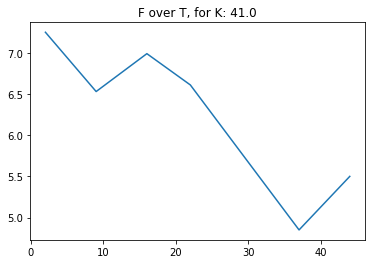

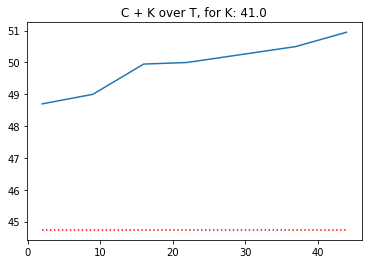

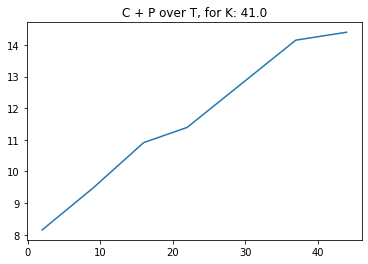

In [17]:
_N_STRIKE = 12
_strike = np.sort(parity['strike'].unique())[_N_STRIKE]
_e = parity[parity['strike'] == _strike]

plt.title(f'F over T, for K: {_strike}')
plt.plot(_e['days_to_expiration'], _e['forward'])
plt.show()

plt.title(f'C + K over T, for K: {_strike}')
plt.plot(_e['days_to_expiration'], _e['call_break_even'])
plt.hlines(
    stocks['open'],
    xmin=_e['days_to_expiration'].min(),
    xmax=_e['days_to_expiration'].max(),
    colors='r',
    linestyles='dotted'
)
plt.show()

plt.title(f'C + P over T, for K: {_strike}')
plt.plot(_e['days_to_expiration'], _e['cumulative_premium'])
plt.show()

### Forward pricing

In [257]:
_COST_OF_CARRY = 0.0002
_RISK_FREE_RATE = 0.0002

def calc_forward_price(
    stock_price: float,
    strike_price: pd.Series,
    days_to_expiration: pd.Series,
    risk_free_rate: float,
    cost_of_carry: float,
) -> pd.Series:
    forward_price = (np.e ** -(risk_free_rate * days_to_expiration)) * (stock_price * np.e ** (cost_of_carry * days_to_expiration) - strike_price)
    return forward_price

parity['_forward'] = calc_forward_price(
    stock_price = stocks['open'].values,
    strike_price = parity['strike'],
    days_to_expiration = parity['days_to_expiration'],
    risk_free_rate = _RISK_FREE_RATE,
    cost_of_carry = _COST_OF_CARRY
)

parity['diff'] = parity['forward'] - parity['_forward']
parity[['strike', 'days_to_expiration', 'call_ask', 'put_ask', 'forward', '_forward', 'diff']].head(10)

,strike,days_to_expiration,call_ask,put_ask,forward,_forward,diff
0,22.5,58.0,26.95,1.49,25.46,22.499492,2.960508
1,22.5,156.0,27.25,0.81,26.44,22.931162,3.508838
2,22.5,275.0,27.25,1.08,26.17,23.444084,2.725916
3,22.5,674.0,27.50,3.80,23.70,25.077460,-1.377460
4,23.0,93.0,26.70,1.00,25.70,22.163846,3.536154
5,23.0,184.0,26.75,0.97,25.78,22.571016,3.208984
6,23.0,303.0,27.25,3.00,24.25,23.092408,1.157592
7,25.0,58.0,24.40,1.56,22.84,20.028324,2.811676
8,25.0,93.0,24.50,1.10,23.40,20.200702,3.199298
9,25.0,156.0,24.30,1.79,22.51,20.507958,2.002042
